In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import numpy as np
from face_alignment import FaceAlignment, LandmarksType
from torchvision import transforms
import PIL
import matplotlib.pyplot as plt

from processVoxCelDataset import *

In [2]:
class metaTrainVideoDataset(Dataset):
    def __init__(self, K, rootDir, outputDir, randomSeed, device='gpu', transform=None):
        self.K = K
        self.rootDir = rootDir
        self.outputDir = outputDir
        self.randomSeed = randomSeed
        self.device = device
        self.transform = transform
        
        self.videoList = generateVideoList(rootDir)
        self.fa = FaceAlignment(LandmarksType._2D, device=device)
    
    def __len__(self):
        return len(self.videoList)
    
    def __getitem__(self, idx):
        # get K+1 frames, K for embedder; 1 for generator
        selectedFrames, landmarkFrames = generateKSelectedFramesAndLandmarksForSpecificVideo(self.K+1, self.videoList[idx], self.outputDir, self.fa, self.randomSeed)
        
        dataFrames = []
        if self.transform:
            for frame, landmark in zip(selectedFrames, landmarkFrames):
                frame = self.transform(PIL.Image.fromarray(frame, 'RGB'))
                landmark = self.transform(PIL.Image.fromarray(landmark, 'RGB'))
                assert torch.is_tensor(frame), "The source images must be converted to Tensors."
                assert torch.is_tensor(landmark), "The landmark images must be converted to Tensors."
                data = torch.stack((frame, landmark), dim=0)
                dataFrames.append(data)
        dataFrames = torch.stack(dataFrames, dim=0)
    
        
        return idx, dataFrames

In [3]:
dataset = metaTrainVideoDataset(
    K = 8,
    rootDir = '../data/train/mp4',
    outputDir = '../data/train/output/', 
    randomSeed = 0,
    device = 'cpu',
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
        ])
    )

dataLoader = DataLoader(dataset, batch_size=2, shuffle=True)

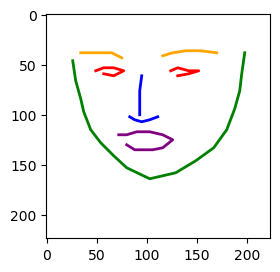

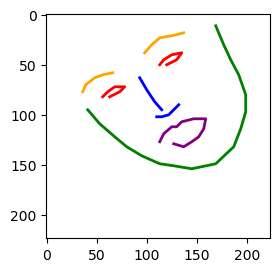

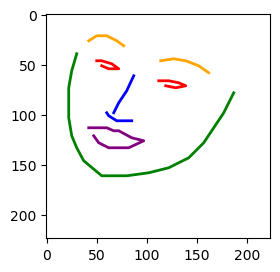

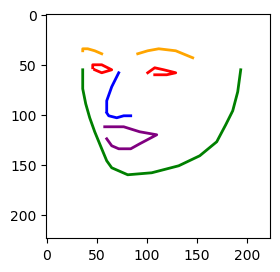

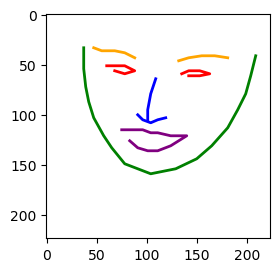

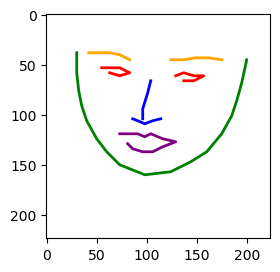

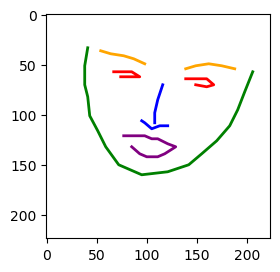

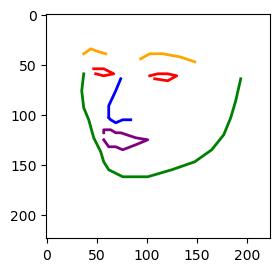

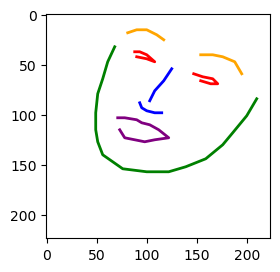

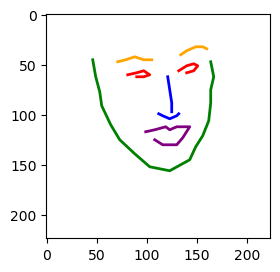

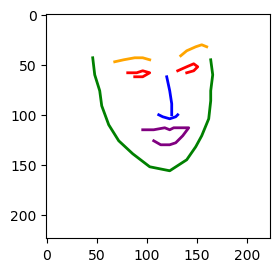

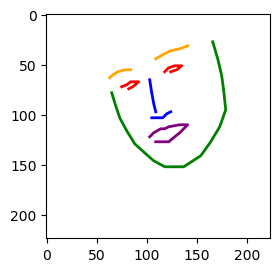

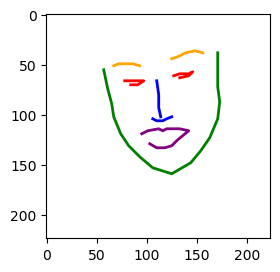

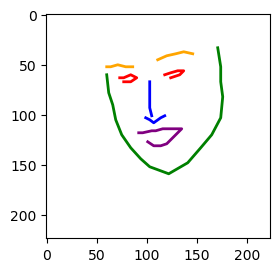

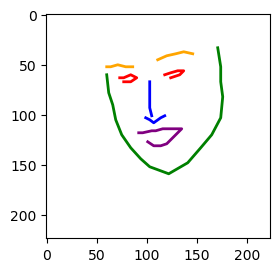

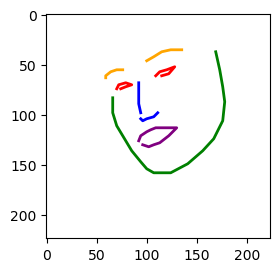

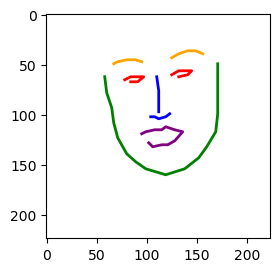

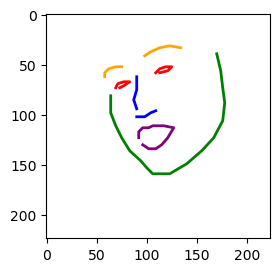

In [4]:
idx, landmarkFrames = next(iter(dataLoader))

In [5]:
len(dataLoader)

484

In [6]:
idx

tensor([778, 842])

In [7]:
landmarkFrames.shape

torch.Size([2, 9, 2, 3, 256, 256])

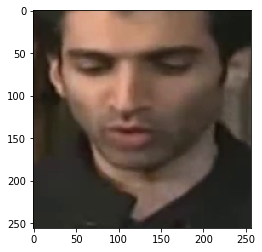

In [11]:
plt.imshow(landmarkFrames[0, 0, 0].permute(1, 2, 0))